# 第2回 ベクトル空間モデル

この演習ページでは，ベクトル空間モデルに基づく情報検索モデルについて説明します．具体的には，文書から特徴ベクトルへの変換方法，TF-IDFの計算方法，コサイン類似度による文書ランキングについて，その実装例を説明します．第2回演習の最終目的は，ある与えられた文書コーパスに対して，TF-IDFで重み付けされた特徴ベクトルによる文書ランキングが実装できるようになることです．

## ライブラリ
この回の演習では，以下のライブラリを使用します．　
- [numpy, scipy](http://www.numpy.org/)
  + Pythonで科学技術計算を行うための基礎的なライブラリ．
- [gensim](https://radimrehurek.com/gensim/index.html)
  + トピックモデリング（LDA）やword2vecなどを手軽に利用するためのPythonライブラリ．
- [nltk (natural language toolkit)](http://www.nltk.org/)
  + 自然言語処理に関するpythonライブラリです．この演習ではストップワードのために用います．ほかにも，単語のステミングやトークナイズなどの機能をはじめ，品詞推定，依存関係分析など自然言語処理のあらゆるメソッドが用意されています．
- [pandas](http://pandas.pydata.org/)
  + pythonでデータ分析をするためのフレームワークです．この演習ではデータをプロットするために用いています．

### ライブラリのインストール

本演習では，gensimとnltkを利用します．
まず，ターミナルを開き以下のコマンドでgensimをインストールしておいてください．

```
conda install gensim
```

次に，pythonを起動し，以下のコマンドから，nltkのcorpusからstopwordsをインストールしておいてください．

```
python 
>>> import nltk
>>> nltk.download()
```

---

## 第2回目の演習の内容
``h29iro/data/`` に `sample.corpus` というファイルを置いています． このファイルには改行区切りで3件の短い文書が保存されています．この演習では，このファイルに対してTF-IDFで重み付けされた特徴ベクトルを作成し，コサイン類似度によるランキングを行います．

## 1. 文書の読み込みとトークナイズ
まずは，`sample.corpus`を読み込み，各文書のBoW表現を抽出します．

In [1]:
import numpy as np
import gensim
from nltk.corpus import stopwords
import nltk
nltk.download()
import pandas as pd
np.set_printoptions(precision=4)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [3]:
# 小数点3ケタまで表示
%precision 3

u'%.3f'

In [4]:
with open("../data/sample.corpus", "r") as f:  #sample.corpusの読み込み
    text = f.read().strip().split("\n") #sample.corpusのテキストデータを取得し，それを改行で分割
text

['I live in kyoto and kyoto is a beautiful city',
 'kyoto was the captial of japan and is in kansai and kansai is in japan',
 'kyoto is in kansai and kyoto is historical city']

３件の文書があることが分かりますね．次に，文章をトークン（単語）に分割します．今回は簡単のため単純にスペース区切りによって単語に分割します．

In [5]:
raw_corpus = [d.lower().split() for d in text] #文章を小文字に変換して単語に分割する
print("d1=" , raw_corpus[0])
print("d2=" , raw_corpus[1])
print("d3=" , raw_corpus[2])

('d1=', ['i', 'live', 'in', 'kyoto', 'and', 'kyoto', 'is', 'a', 'beautiful', 'city'])
('d2=', ['kyoto', 'was', 'the', 'captial', 'of', 'japan', 'and', 'is', 'in', 'kansai', 'and', 'kansai', 'is', 'in', 'japan'])
('d3=', ['kyoto', 'is', 'in', 'kansai', 'and', 'kyoto', 'is', 'historical', 'city'])


文が単語の集合に変換されました．しかし，この単語集合には "i" や "of" などのストップワードが含まれています．そこで，ストップワードを除去してみましょう．

ストップワードのリストはネットで探せば様々な種類が見つかります．ここでは，nltkのstopwordsモジュールを利用します．

In [6]:
# stopwords.words("english")に含まれていない単語のみ抽出
corpus = [list(filter(lambda word: word not in stopwords.words("english"), x)) for x in raw_corpus] 
print("d1=" , corpus[0])
print("d2=" , corpus[1])
print("d3=" , corpus[2])

('d1=', ['live', 'kyoto', 'kyoto', 'beautiful', 'city'])
('d2=', ['kyoto', 'captial', 'japan', 'kansai', 'kansai', 'japan'])
('d3=', ['kyoto', 'kansai', 'kyoto', 'historical', 'city'])


## 2. 特徴ベクトルの生成
次に文書の特徴ベクトルを生成します．ここからの流れは，以下の通りになります．

1. 文書集合（corpus）から 単語->単語ID の辞書 (dictionary) を作成する．
2. 作成された辞書を基に，文書を (単語ID，出現回数）の集合 (id_corpus) として表現する．
3. id_corpusからTfidfModelを用いて，TF-IDFで重み付けされた特徴ベクトルを作成する．

まずは，文書集合（コーパス）から単語->単語ID の辞書 (dictionary) を作成します．


In [8]:
dictionary = gensim.corpora.Dictionary(corpus) #コーパスを与えて，単語->IDの辞書を作成する
dictionary.token2id #作成された辞書の中身

{u'beautiful': 0,
 u'captial': 4,
 u'city': 1,
 u'historical': 7,
 u'japan': 5,
 u'kansai': 6,
 u'kyoto': 2,
 u'live': 3}

このdictionaryを用いて，文書の単語をID化します．

In [9]:
id_corpus = [dictionary.doc2bow(document) for document in corpus]
id_corpus

[[(0, 1), (1, 1), (2, 2), (3, 1)],
 [(2, 1), (4, 1), (5, 2), (6, 2)],
 [(1, 1), (2, 2), (6, 1), (7, 1)]]

作成されたid_corpusは，たとえば，1件目の文書は

In [10]:
id_corpus[0]

[(0, 1), (1, 1), (2, 2), (3, 1)]

という内容になっています．たとえば，(0,2)というデータは
```
単語ID0の単語が２回出現
```
という内容を表しています． つまり，単語の出現頻度(term frequency)のみで文書を特徴ベクトル化したことになります．なお，これをnumpyのベクトルとして抽出したければ，corpus2denseメソッドを用います．

In [11]:
tf_vectors = gensim.matutils.corpus2dense(id_corpus, len(dictionary)).T
print("d1=", tf_vectors[0])
print("d2=", tf_vectors[1])
print("d3=", tf_vectors[2])

('d1=', array([1., 1., 2., 1., 0., 0., 0., 0.], dtype=float32))
('d2=', array([0., 0., 1., 0., 1., 2., 2., 0.], dtype=float32))
('d3=', array([0., 1., 2., 0., 0., 0., 1., 1.], dtype=float32))


今回用意したコーパスは語彙数が8しかありませんが，実際のケースでは，この特徴ベクトルは非常に疎になることが容易に想像つくと思います．

さて，id_corpusからTFIDFで重み付けされた特徴ベクトルを得るには， models.TfidfModel メソッドを用います．

In [12]:
tfidf_model = gensim.models.TfidfModel(id_corpus, normalize=False) #normalize=Trueにすると，文書長によってtfを正規化する
tfidf_corpus = tfidf_model[id_corpus] #id_corpusをtfidfで重み付けされたものに変換

これでTF-IDFで重み付けされた特徴ベクトルが得られました．たとえば，1件目の文書$d_1$に対する特徴ベクトル${\mathbf d}_1$の中身を見てみます．

In [13]:
tfidf_corpus[0]

[(0, 1.585), (1, 0.585), (3, 1.585)]

TFIDFの値は，(単語ID，重み） として得られています．単語IDを実際の単語に変換するにはdictionaryを通します．

In [14]:
[(dictionary[x[0]], x[1]) for x in tfidf_corpus[0]]#dictionary[token_id]でアクセスすると実際の単語が返ってくる

[(u'beautiful', 1.585), (u'city', 0.585), (u'live', 1.585)]

同様に2件目の文書$d_2$についても見てみます．

In [15]:
doc2 = [(dictionary[x[0]], x[1]) for x in tfidf_corpus[1]]
doc2

[(u'captial', 1.585), (u'japan', 3.170), (u'kansai', 1.170)]

たとえば， 文書$d_{2}$における`japan`のTFIDF値が本当に正しいのか検証してみましょう．

$tfidf_{d_2, japan} = tf_{d_2, japan} \log \frac{N}{df_{japan}}$ ,

いま， $tf_{d_2, japan} = 2$, $N = 3$, $df_{japan}$ = 1 ですので，

$tfidf_{d_2, japan} = 2 \log 3 = 3.170$
となり，gensimで得られた結果と一致していることが分かります．

In [28]:
import math
2* math.log(3,2) #2log3の計算方法

3.170

# 3. コサイン類似度
それでは，コサイン類似度による文書ランキングを行ってみましょう．

クエリと文書の類似度を測る前に，まずは文書同士のコサイン類似度を計算してみます． コサイン類似度の計算はgensimでも良いのですが，ここでは，いったんnumpyのベクトルを取得して，そのベクトルに対してコサイン類似度を計算してみます．

In [29]:
# 各文書のtfidfベクトルを取得
tfidf_vectors = gensim.matutils.corpus2dense(tfidf_corpus, len(dictionary)).T
print ("d1=", tfidf_vectors[0])
print ("d2=", tfidf_vectors[1])
print ("d3=", tfidf_vectors[2])

('d1=', array([1.585, 0.585, 0.   , 1.585, 0.   , 0.   , 0.   , 0.   ],
      dtype=float32))
('d2=', array([0.   , 0.   , 0.   , 0.   , 1.585, 3.17 , 1.17 , 0.   ],
      dtype=float32))
('d3=', array([0.   , 0.585, 0.   , 0.   , 0.   , 0.   , 0.585, 1.585],
      dtype=float32))


In [30]:
# コサイン類似度を計算する関数を用意
from scipy.spatial.distance import cosine
def cosine_sim(v1, v2):
    #scipyのcosineは類似度ではなく距離関数のため， 1-コサイン距離　とすることで，コサイン類似度に変換する
    return 1.0 - cosine(v1, v2) 

In [31]:
# 各文書間のコサイン類似度を計算してみる
print ("sim(d1, d2)=", cosine_sim(tfidf_vectors[0], tfidf_vectors[1]))
print ("sim(d2, d3)=", cosine_sim(tfidf_vectors[1], tfidf_vectors[2]))
print ("sim(d1, d3)=", cosine_sim(tfidf_vectors[0], tfidf_vectors[2]))

('sim(d1, d2)=', 0.0)
('sim(d2, d3)=', 0.10256209224462509)
('sim(d1, d3)=', 0.08261892944574356)


それでは，クエリを特徴ベクトルに変換し，クエリと文書のコサイン類似度を求めていきましょう．

In [32]:
q = {"kansai", "japan"}
tfidf_q = tfidf_model[dictionary.doc2bow(q)]  #クエリをtfidfベクトルに変換
query_vector = gensim.matutils.corpus2dense([tfidf_q], len(dictionary)).T[0] #numpyのベクトルに変換
print ("q=", query_vector)

('q=', array([0.   , 0.   , 0.   , 0.   , 0.   , 1.585, 0.585, 0.   ],
      dtype=float32))


In [33]:
print([(dictionary[x[0]], x[1]) for x in tfidf_q])

[(u'japan', 1.5849625007211563), (u'kansai', 0.5849625007211562)]


In [34]:
print ("sim(q, d1) = ", cosine_sim(query_vector, tfidf_vectors[0]))
print ("sim(q, d2) = ", cosine_sim(query_vector, tfidf_vectors[1]))
print ("sim(q, d3) = ", cosine_sim(query_vector, tfidf_vectors[2]))

('sim(q, d1) = ', 0.0)
('sim(q, d2) = ', 0.9053466320037842)
('sim(q, d3) = ', 0.1132848858833313)


この結果から，q={"kansai", "japan"} というクエリに対しては，$d_2,d_3, d_1$の順でランク付けされることが分かります．

## 4. ベクトル空間の可視化

最後に，得られた特徴ベクトルを可視化してみましょう．特徴ベクトルそのものは多次元（今回の場合は8次元）ですが，これを次元削減の手法を使って，2次元空間に射影してみます．今回は，`LSI`（Latent Semantic Indexing)という手法を用いて，特徴ベクトルを2次元空間に落とし込みます．LSIについては，講義で触れるかもしれません（講義の進み方次第）．

In [35]:
import matplotlib.pylab as plt

In [36]:
%matplotlib inline

In [37]:
# LSIにより特徴ベクトルを2次元に落とし込む
lsi = gensim.models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=2)
lsi_corpus = lsi[tfidf_corpus]
lsi_vectors = gensim.matutils.corpus2dense(lsi_corpus, 2).T
print("d1=", lsi_vectors[0])
print("d2=", lsi_vectors[1])
print("d3=", lsi_vectors[2])
query_lsi_corpus = lsi[[tfidf_q]] 
query_lsi_vector = gensim.matutils.corpus2dense(query_lsi_corpus, 2).T[0]
print ("q=", query_lsi_vector)

('d1=', array([-0.009, -2.302], dtype=float32))
('d2=', array([-3.73 ,  0.028], dtype=float32))
('d3=', array([-0.237, -0.346], dtype=float32))
('q=', array([-1.53 ,  0.007], dtype=float32))


In [38]:
# 散布図にプロットするため，DataFrameに変換
axis_names = ["z1", "z2"]
doc_names = ["d1", "d2", "d3", "q"]
df = pd.DataFrame(np.r_[lsi_vectors, [query_lsi_vector]], 
                  columns=axis_names, index=doc_names) # np.r_ は行列同士の連結
df

,z1,z2
d1,-0.009431,-2.301599
d2,-3.730471,0.027818
d3,-0.237208,-0.345971
q,-1.529893,0.007460


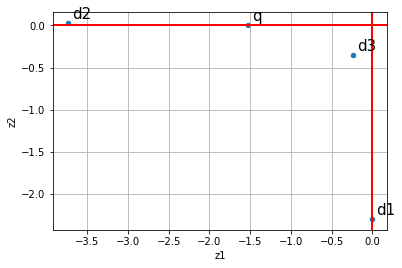

In [39]:
# 散布図をプロット
fig, ax = plt.subplots()
df.plot.scatter(x="z1", y="z2", ax=ax)
ax.axvline(x=0, lw=2, color='red') #x軸とy軸に線を引く
ax.axhline(y=0, lw=2, color='red') 
ax.grid(True)
for k, v in df.iterrows():
    ax.annotate(k, xy=(v[0]+0.05,v[1]+0.05),size=15) #データ点にラベル名を付与

この図を見てみると，やはりクエリ$q$と文書$d_2$はほぼ同じ方向（つまり，コサイン類似度が１に近い）であることがわかり， $q$と$d_1$の角度はほぼ直角（つまりコサイン類似度が0）であることがわかります．

----

# 演習課題その1 ベクトル空間モデル

## 必須課題（1） 与えられたコーパスに対する検索の実現

以下からコーパスを1つ以上選択し，ベクトル空間モデルに基づいた検索を実現せよ．３種類以上のクエリでの検索結果を示すこと．


1. 京都観光に関する83件の文書（h29iro/data/kyoto_results_100.json）
2. 各自で用意したコーパス．ただし，100件以上の文書数を含むこと．もっと多くてもよい．
3. Wikipedia（[参考: gensim Tutorial](https://radimrehurek.com/gensim/wiki.html) ）※ただし，モデル構築にとんでもない時間がかかるそうなので覚悟すること．


- ページに表示する検索結果は各クエリ5-10件程度で良い．

In [70]:
# 1.のコーパスはjson形式で保管されている．
import json
with open("../data/kyoto_results_100.json", "r") as f:
    docs = json.load(f)
print("Num of docs = ", len(docs))
docs[0]

('Num of docs = ', 83)


{u'bow': u'\u5b9a\u756a \u7a74\u5834 \u304a \u30b9\u30b9\u30e1 \u4eac\u90fd \u89b3\u5149 ...- NAVER \u307e\u3068\u3081 \u95a2\u897f \u4f4f\u3093 \u3044\u308b \u4f5c\u8005 \u304a \u30b9\u30b9\u30e1 \u4eac\u90fd \u89b3\u5149 \u540d\u6240 \u307e\u3068\u3081 \u307e\u3057 \u305f \u5b9a\u756a \u7a74\u5834 \u30b9\u30dd\u30c3\u30c8 \u968f\u6642 \u307e\u3068\u3081 \u3044\u304d \u307e\u3059 \u662f\u975e \u4eac\u90fd \u89b3\u5149 \u53c2\u8003 \u3057 \u4e0b\u3055\u3044',
 u'summary': u'\u95a2\u897f\u306b\u4f4f\u3093\u3067\u3044\u308b\u4f5c\u8005\u304c\u304a\u30b9\u30b9\u30e1\u306e\u4eac\u90fd\u306e\u89b3\u5149\u540d\u6240\u3092\u307e\u3068\u3081\u307e\u3057\u305f \u5b9a\u756a\u304b\u3089\u7a74\u5834\u306e\u30b9\u30dd\u30c3\u30c8\u3092\u968f\u6642\u307e\u3068\u3081\u3066\u3044\u304d\u307e\u3059\uff01\u662f\u975e\u3001\u4eac\u90fd\u89b3\u5149\u306e\u53c2\u8003\u306b\u3057\u3066\u4e0b\u3055\u3044\u3002',
 u'title': u'\u3010\u5b9a\u756a\u304b\u3089\u7a74\u5834\u307e\u3067\u3011\u304a\u30b9\u30b9\u30e1

In [152]:
# `bow`　には形態素解析でトークン化された単語列がスペース区切りで保存されている．
# これを使用して特徴ベクトルを作成するとよい．
docs[0]["bow"]

u'\u5b9a\u756a \u7a74\u5834 \u304a \u30b9\u30b9\u30e1 \u4eac\u90fd \u89b3\u5149 ...- NAVER \u307e\u3068\u3081 \u95a2\u897f \u4f4f\u3093 \u3044\u308b \u4f5c\u8005 \u304a \u30b9\u30b9\u30e1 \u4eac\u90fd \u89b3\u5149 \u540d\u6240 \u307e\u3068\u3081 \u307e\u3057 \u305f \u5b9a\u756a \u7a74\u5834 \u30b9\u30dd\u30c3\u30c8 \u968f\u6642 \u307e\u3068\u3081 \u3044\u304d \u307e\u3059 \u662f\u975e \u4eac\u90fd \u89b3\u5149 \u53c2\u8003 \u3057 \u4e0b\u3055\u3044'

## 以下が課題のコード

In [154]:
# --- 1.文字の読み込みとトークナイズ ---
# スペース区切りで単語を分割する
raw_corpus = [d["bow"].split() for d in docs]

# ストップワードを除去する(TODO: 日本語はどうやる?不要?)
# corpus = corpus = [list(filter(lambda word: word not in stopwords.words("english"), x)) for x in raw_corpus] 

# --- 2.特徴ベクトルの作成 ---

# コーパスを与えて、単語->IDの辞書を作成する
dictionary = gensim.corpora.Dictionary(raw_corpus) 

# 文書の単語をID化
id_corpus = [dictionary.doc2bow(document) for document in raw_corpus]

# id_courpusからIFIDFで重み付けされた特徴ベクトルを得る
tfidf_model = gensim.models.TfidfModel(id_corpus, normalize=False) 
# id_corpusをtfidfで重み付けされたものに変換
tfidf_corpus = tfidf_model[id_corpus] 

# --- 3.コサイン類似度 ---
#今回の課題ではコサイン類似度を元にランキングを行う
tfidf_vectors = gensim.matutils.corpus2dense(tfidf_corpus, len(dictionary)).T

# クエリによる検索
qs = [{"京都"}, {"観光"}, {"おすすめ"}]

# クエリを特徴ベクトルに変換
tfidf_qs = [ tfidf_model[dictionary.doc2bow(qs[i])] for i in range(3)  ]
query_vectors =  [gensim.matutils.corpus2dense([tfidf_qs[i]], len(dictionary)).T[0]  for i in range(3)]

# コサイン類似を求め、ランキングにする
query_rankings =  [np.argsort([cosine_sim(query_vectors[i], tfidf_vectors[x]) for x in range(83)])[::-1]  for i in range(3)]

# ランキングを表示する
for i in range(3):
    print "----------------------------"
    print "クエリ"
    print ["京都", "観光", "おすすめ"][i]
    print ""
    for j in range(5):
        print docs[query_rankings[i][j]]["title"]
        print docs[query_rankings[i][j]]["url"]
    print "----------------------------"
    print ""

----------------------------
クエリ
京都

旬の京都観光情報と 京都のおすすめ観光スポット | 京都観光総 ...
https://kyoto-design.jp
京都観光オフィシャルサイト 京都観光Navi
https://kanko.city.kyoto.lg.jp
京都観光地おすすめランキング - コトログ京都
www.kotolog.jp
京都観光 おすすめ観光スポット・世界遺産・グルメのまとめ
homepage2.nifty.com/otokulink/kyoto_top.html
季節の散策コース｜観光ガイド｜そうだ 京都、行こう。～京都 ...
souda-kyoto.jp/travel/walk
----------------------------

----------------------------
クエリ
観光

旬の京都観光情報と 京都のおすすめ観光スポット | 京都観光総 ...
https://kyoto-design.jp
観光バスツアー・観光タクシー | 京都の観光&遊び・体験 ...
www.veltra.com/jp/japan/kyoto/ctg/7185:Bus_Tours
「 京都観光タクシー 」 格安で有意義な京都観光をお約束！
www.kyoto.cc/index.htm
京都観光おすすめのグルメや人気の穴場
trendnews-kyoto-0909.com
京都観光/旅行・ぶらり伏見
kyoto-fushimi.sakura.ne.jp
----------------------------

----------------------------
クエリ
おすすめ

京都観光おすすめのグルメや人気の穴場
trendnews-kyoto-0909.com
京都観光 | 京都の観光を楽しむならきょうと情報版
www.kyotojoho.co.jp
京都観光地おすすめランキング - コトログ京都
www.kotolog.jp
旬の京都観光情報と 京都のおすすめ観光スポット | 京都観光総 ...
https://kyoto-design.jp
京都観光のおすすめコースをガイド | 京都じっくり観光
www.kyotokanko.co.jp
---------------------

## 任意課題（a） Okapi BM25

上記（１）に対して， Okapi BM25 に基づくランキングを行い，上記（１）の結果と比較してみよ．また，結果が変わらない場合は，結果が変わるような文書例を自分で考えてみよ．

## 任意課題（b） 適合性フィードバック

適合性フィードバックによるクエリ修正を行い，検索結果がどのように変化するのか分析せよ．また，コーパス及びクエリを可視化することで，修正されたクエリが適合・不適合文書の特徴ベクトルにどのように影響されているか幾何的に分析せよ．


# 課題の提出方法

いずれかの方法で，ipython notebookのページ（.ipynbファイル）とそのhtml版を提出すること．

1. 添付ファイルで山本に送信．
   - 送付先 tyamamot at dl.kuis.kyoto-u.ac.jp
2. 各自のgithubやgithub gistにアップロードし，そのURLを山本に送信．この場合はhtml版を用意する必要はない．
3. 上記以外で，山本が実際に.ipynbファイルを確認できる方法．


# 締切

- 2018年1月25日（金）23:59
- 締切に関する個別の相談は``受け付けます``．